# EN3150 Assignment03- Custom convolutional neural network to perform classification.

# Custom Model

## 1. Data Preparation

In [1]:
# Importing required libraries
import os
import random
import torch
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision import datasets, transforms
from PIL import Image

from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

### 1.1 Data Loading

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors and scale to [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # Normalize to mean=0.5, std=0.5
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Combine into a single full dataset
full_dataset = ConcatDataset([train_dataset, test_dataset])

### 1.2 Data spliting and Loading

In [3]:
# Split the dataset into 70/15/15
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

In [4]:
# Load the data into DataLoader for batching
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# CNN Model Implementation

In [5]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # 1st Conv Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        self.pool1 = nn.MaxPool2d(2, 2)

        # 2nd Conv Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization
        self.pool2 = nn.MaxPool2d(2, 2)

        # 3rd Conv Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        # Classifier
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

## Model Training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
num_epochs = 20

### Training

In [7]:
def train_with_optimizer(optimizer_name, lr=0.001, momentum=0.9):
    model = CustomCNN().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "SGD_MOM":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, val_accs = [], [], []
    for epoch in range(20):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"[{optimizer_name}] Epoch {epoch+1}: Train loss {train_loss:.4f} | Val loss {val_loss:.4f} | Acc {val_acc:.2f}%")

    return model, train_losses, val_losses, val_accs

In [8]:
model,train_losses, val_losses, val_accs = train_with_optimizer("SGD_MOM", lr=0.01, momentum=0.9)

[SGD_MOM] Epoch 1: Train loss 0.2155 | Val loss 0.0515 | Acc 98.37%
[SGD_MOM] Epoch 2: Train loss 0.0548 | Val loss 0.0384 | Acc 98.76%
[SGD_MOM] Epoch 3: Train loss 0.0383 | Val loss 0.0497 | Acc 98.41%
[SGD_MOM] Epoch 4: Train loss 0.0286 | Val loss 0.0313 | Acc 98.92%
[SGD_MOM] Epoch 5: Train loss 0.0246 | Val loss 0.0452 | Acc 98.69%
[SGD_MOM] Epoch 6: Train loss 0.0190 | Val loss 0.0452 | Acc 98.76%
[SGD_MOM] Epoch 7: Train loss 0.0171 | Val loss 0.0471 | Acc 98.74%
[SGD_MOM] Epoch 8: Train loss 0.0130 | Val loss 0.0322 | Acc 99.05%
[SGD_MOM] Epoch 9: Train loss 0.0105 | Val loss 0.0359 | Acc 99.07%
[SGD_MOM] Epoch 10: Train loss 0.0069 | Val loss 0.0343 | Acc 99.22%
[SGD_MOM] Epoch 11: Train loss 0.0076 | Val loss 0.0457 | Acc 98.83%
[SGD_MOM] Epoch 12: Train loss 0.0058 | Val loss 0.0362 | Acc 99.12%
[SGD_MOM] Epoch 13: Train loss 0.0064 | Val loss 0.0508 | Acc 98.85%
[SGD_MOM] Epoch 14: Train loss 0.0070 | Val loss 0.0437 | Acc 98.95%
[SGD_MOM] Epoch 15: Train loss 0.0057 | Val

### Plot Training and Validation Loss

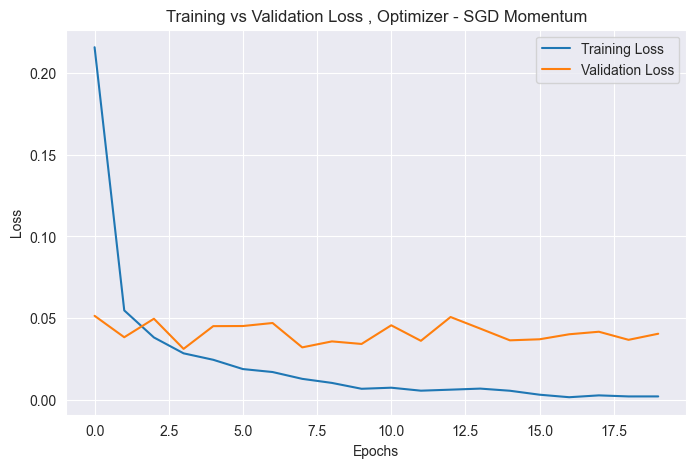

In [9]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss , Optimizer - SGD Momentum')
plt.legend()
plt.show()

### Evaluate Model


Test Accuracy : 99.35%
Precision     : 99.35%
Recall        : 99.35%
F1 Score      : 99.35%

Detailed classification report:

              precision    recall  f1-score   support

           0     0.9972    0.9927    0.9949      1089
           1     0.9933    0.9975    0.9954      1182
           2     0.9962    0.9952    0.9957      1043
           3     0.9956    0.9965    0.9961      1140
           4     0.9941    0.9960    0.9951      1011
           5     0.9890    0.9923    0.9906       905
           6     0.9959    0.9919    0.9939       985
           7     0.9944    0.9926    0.9935      1082
           8     0.9833    0.9941    0.9887      1010
           9     0.9952    0.9858    0.9905      1053

    accuracy                         0.9935     10500
   macro avg     0.9934    0.9934    0.9934     10500
weighted avg     0.9935    0.9935    0.9935     10500



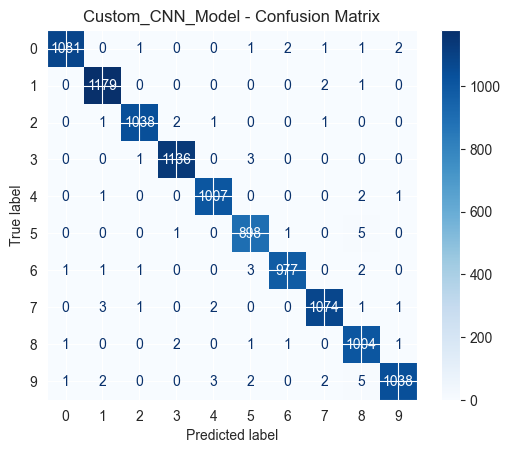

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Classification metrics ---
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\nTest Accuracy : {acc*100:.2f}%")
print(f"Precision     : {prec*100:.2f}%")
print(f"Recall        : {rec*100:.2f}%")
print(f"F1 Score      : {f1*100:.2f}%")

# Optional: detailed class-wise metrics
print("\nDetailed classification report:\n")
print(classification_report(all_labels, all_preds, digits=4))

# --- Confusion matrix ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='Blues', values_format='d')
plt.title("Custom_CNN_Model - Confusion Matrix")
plt.show()
